# Relational Measurement Package


## Data Structure
 
 * raw [2D array of raw values]
 * network [array of dicts]
  * messages [array of values by timeslice]
  * entropies [array of entropies by timeslice]
 * nodes [array of dicts]
  * id [string]
  * messages_sent [list of lists: [total value sent, dict of all ids sent]]
  * messages_recieved [list of list: [total value received, dict of all ids received]]
  * probabilities [array of dicts by timeslice]
  * entropies [array of entropies by timeslice]

## Core Functions



*input* (file)
 - Pulls in data in CSV format of format:
     _to_, _from_, _timestamp_, _value_ (optional)
 - Stores it as an array of tuples called raw_data
 - Stores values based on _value_ column or sets to 1 
 - calculates entropies and probabilities
 - _returns null_

*init* (timeslice_size, sc)
 - timeslice_size: determines the size of each timeslice.
 - sc: smoothing constant used to calculate probabilities
 - sets constants
 - _returns null_
 
*timeslice* (raw)
 - stores inputted data by timeslice

*calculate_probabilities* (self)
 - calculates probabilities for each timeslice
 
*calculate_entropies* (self)
 - calculates entropy values for each timeslice
 
*display_entropy* (self, nodes(optional), timeslice_range(optional))
 - shows a graph of entropy
 
*display_graph* (self, timeslice, nodes(optional)
 - shows a graph visualization of nodes at a given timeslice

In [21]:
from random import random
from math import log, ceil, floor
from pyvis import network as net
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


class Relmeasure:
    #
    # Timeslice_size: Int = chunks of time used to divide messages for analysis in seconds.
    # Smoothing: Float = Value between 0 and 1 that defines how strongly recent messages shift the probability distribution of each node.
    # Data: Array of metadata about a series of messages = [[Sender, Recipient, Timestamp]]
    # 
    def __init__(self, timeslice_size, smoothing, data):
        self.timeslice_size = timeslice_size
        self.smoothing = smoothing
        self.raw = data
        self.network = {}
        self.nodes = []
        
    def entropy(self, probabilities):
        entropy = 0
        for k in probabilities.keys():
            p = probabilities[k]
            if (p > 0):
                entropy += p * log(p)
        return entropy
    
    def probabilities(self, node_val, total_val, num_nodes, last_probs):
        if total_val == 0:
            return last_probs
        return last_probs * (1 + self.smoothing*(node_val/total_val - 1/(num_nodes - 1)))
    
    def init_nodes(self):
        self.raw.sort(key=lambda node:node[2])
        num_slices = ceil((self.raw[-1][2] - self.raw[0][2])/self.timeslice_size) + 1
        self.min_time = self.raw[0][2]
        self.max_time = self.raw [-1][2]
        self.num_slices = num_slices
        ids = []
        template_dict = {}
        template1 = [[0, {}] for x in range(num_slices)]
        template2 = [0 for x in range(num_slices)]  
        self.network = {'msg_vals':template2.copy(), 'entropies':template2.copy()}
        
        ids = []
        for message in self.raw:
            if not (message[0] in ids):
                ids.append(message[0])
#             if not (message[1] in ids):
#                 ids.append(message[1])

        self.num_nodes = len(ids)
        
        template_dict = {}
        template_probs = {}
        for i in ids:
            template_probs[i] = float(1/self.num_nodes)
        
        template1 = [[0, template_dict.copy()] for x in range(num_slices)]
        template2 = [0 for x in range(num_slices)]
        template3 = [template_probs.copy() for y in range(num_slices)]
        
        for i in ids:
            self.nodes.append({'id':i, 'msg_sent':template1.copy(), 'msg_rcvd':template1.copy(), 'probs':template3.copy(), 'entropies':template2.copy()})
     
    def timeslice(self):
        for message in self.raw:
            sender = message[0]
            recipient = message[1]
            ts = max(ceil((message[2] - self.min_time)/self.timeslice_size) -1, 0)
            if len(message) == 4:
                val = message[3]
            else:
                val = 1
            try:
                self.network['msg_vals'][ts] += val
            except:
                print(len(self.network['msg_vals']), ts)
            
            for n in self.nodes:
                if n['id'] == sender:
                    n['msg_sent'][ts][0] += val
                    if recipient in n['msg_sent'][ts][1]:
                        n['msg_sent'][ts][1][recipient] += val
                    else:
                        n['msg_sent'][ts][1][recipient] = val
                if n['id'] == recipient:
                    n['msg_rcvd'][ts][0] += val
                    if sender in n['msg_rcvd'][ts][1]:
                        n['msg_rcvd'][ts][1][sender] += val
                    else:
                        n['msg_rcvd'][ts][1][sender] = val
    
    def calculate_probs(self):
        for node in self.nodes:
            for ts in range(len(node['msg_sent'])):
                if ts == 0:
                    continue
                for prob_key in node['probs'][ts]:
                    #By default, assume that the probability this timeslice is what it was last timeslice.
                    node['probs'][ts][prob_key] = node['probs'][ts - 1][prob_key]
                for key in node['msg_sent'][ts][1].keys():
                    #If a message was send, update the probability
                    node_val = node['msg_sent'][ts][1][key]
                    total_val = node['msg_sent'][ts][0]
                    last_probs = node['probs'][ts - 1][key]
                    node['probs'][ts][key] = self.probabilities(node_val, total_val, self.num_nodes, last_probs)
    
    def calculate_entropies(self):
        for node in self.nodes:
            for i in range(len(node['probs'])):
                node['entropies'][i] = self.entropy(node['probs'][i])
                self.network['entropies'][i] += node['entropies'][i]
                
    def display_entropy(self, nodes=[], start=None, stop=None):
        fig, ax = plt.subplots()
        start_ts = 0
        if start == None or stop == None:
            s = slice(None)
        else:
            start_ts = floor(start/self.timeslice_size)
            s = slice(start_ts, floor(stop/self.timeslice_size))
        if nodes == []:
            y_axis = self.network['entropies'][s]
            label = 'Network'
        else:
            y_axis = [0 for x in range(self.num_slices)]
            label='Limited Nodes'
            
            for node in nodes:
                for i in range(len(self.network['entropies'][s])):
                    y_axis[i] += node['entropies'][i + start_ts]
        x_axis = range(0, len(y_axis))
        ax.plot(x_axis, y_axis, label="Limited Nodes")

        plt.show()
    
    def display_graph(self, timeslice):
        n = net.Network(notebook=True)
        node_ids = [self.nodes[i]['id'] for i in range(len(self.nodes))]
        n.add_nodes(node_ids)
        for i in range(len(node_ids)):
            node = self.nodes[i]
            for key in node['probs'][timeslice].keys():
                n.add_edge(node_ids[i], key, length=60/node['probs'][timeslice][key], value=node['probs'][timeslice][key]) 
        n.show_buttons()
        return n

In [22]:
class Relmeasure_test:
    def __init__(self):
        data = [
            ['a', 'b', 0],
            ['a', 'b', 100],
            ['b', 'c', 200],
            ['b', 'a', 1100],
            ['c', 'b', 1200],
            ['a', 'b', 1250],
            ['a', 'b', 1500],
            ['b', 'a', 2100],
            ['c', 'd', 2200],
            ['d', 'a', 2300],
            ['c', 'b', 2400],
            ['d', 'a', 2500]
        ]
        self.r = Relmeasure(500, 0.3, data)

        
    def test_entropy(self):
        print("")
        print("__Entropy Test__")
        self.__init__()
        print(self.r.entropy({'a':.1, 'b':.1, 'c':.3, 'd':.2, 'e':.1, 'f':.1, 'h':0, 'i':.1}) == 1.8343719702816235)
    
    def test_probabilities(self):
        print("")
        print("__Probabilities Test__")
        self.__init__()
        print(self.r.probabilities(5, 7, 10, .3) == 0.35428571428571426)
    
    def test_init_nodes(self):
        print("")
        print("__Node Init Test__")
        self.__init__()
        self.r.init_nodes()
        print(self.r.num_nodes == 4)
        print(self.r.nodes[0]['msg_sent'][0][0] == 0)
        print(self.r.nodes[0]['msg_sent'][0][1] == {'a': 0, 'b': 0, 'c': 0, 'd': 0})
        print(len(self.r.nodes[0]['msg_sent']) == 5)
        print(self.r.nodes[0]['probs'][0]['a'] == .25)
        print(len(self.r.network['msg_vals']) == 5) 
        print(len(self.r.network['entropies']) == 5)
    
    def test_timeslice(self):
        print("")
        print("_Timeslice Test_")
        self.__init__()
        self.r.init_nodes()
        self.r.timeslice()
        print(self.r.nodes[0]['msg_sent'][0][0] == 6)
        print(self.r.network['msg_vals'][0] == 3)
    
    def test_calc_probs(self):
        print("")
        print("_Probabilities Calculation Test_")
        self.__init__()
        self.r.init_nodes()
        self.r.timeslice()
        self.r.calculate_probs()
        print(self.r.nodes[0]['probs'][3]['a'] == 0.253125)
        
    def test_calc_entropies(self):
        print("")
        print("_Entropies Calculation Test_")
        self.__init__()
        self.r.init_nodes()
        self.r.timeslice()
        self.r.calculate_probs()
        self.r.calculate_entropies()
        print(self.r.nodes[0]['entropies'][4] == 1.3642676316754974)
        print(self.r.network['entropies'][4] == 5.457070526701989)
    
    def tests(self):
        self.test_entropy()
        self.test_probabilities()
        self.test_init_nodes()
        self.test_timeslice()
        self.test_calc_probs()
        self.test_calc_entropies()
        self.r.display_entropy([self.r.nodes[1], self.r.nodes[2]], 0, 5500)
        self.r.display_graph(2)


__Entropy Test__
False

__Probabilities Test__
True

__Node Init Test__
True
True
False
False
True
False
False

_Timeslice Test_
True
True

_Probabilities Calculation Test_
True

_Entropies Calculation Test_
False
False


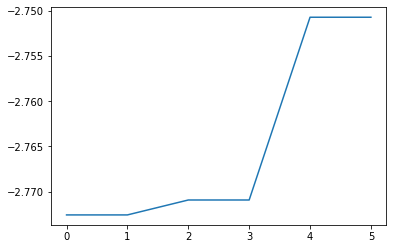

In [23]:
r = Relmeasure_test()
r.tests()

## Now to import from the Enron dataset....

In [24]:
import os
import re
import datetime
notebook_path = os.path.abspath("RML Package.ipynb")

messages = []
directories = os.listdir(os.path.join(os.path.dirname(notebook_path), "maildir/"))
for directory in directories:
    try:
        files = os.listdir(os.path.join(os.path.dirname(notebook_path), "maildir/", directory, 'sent'))
    except:
        print('No sent folder')
        continue
    for filename in files:
        filepath = os.path.join(os.path.dirname(notebook_path), "maildir/", directory, 'sent', filename)
        file = open(filepath)
        try:
            em = ' '.join(file.readlines())
        except:
            print('Unicode error')
        try:
            to_addrs = re.findall("[^-]To: ([^/\n]+)", em)[0].split(', ')
        except:
            print('No to field')
            continue
        from_addr = re.findall("[^-]From: ([^/\n]+)", em)[0]
        date_text = re.findall("Date: ([^/\n]+)", em)[0]
        # For some reason the python library won't support this non-zero-padded format, so add a zero
        if re.search(', [1-9]{1} ', date_text):
            date_text = date_text[:5] + '0' + date_text[5:]
        date_time_obj = datetime.datetime.strptime(date_text, '%a, %d %b %Y %H:%M:%S %z (%Z)')
        date_ts = date_time_obj.timestamp()
        for to_addr in to_addrs:
            messages.append([from_addr, to_addr, date_ts])
        file.close()

print('Done!')

No to field
No sent folder
No to field
No to field
No to field
No to field
No to field
No sent folder
No to field
No sent folder
No sent folder
No sent folder
No to field
No sent folder
No to field
No sent folder
No sent folder
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No sent folder
No to field
No to field
No to field
No to field
No to field
No to field
No sent folder
No sent folder
No sent folder
No sent folder
No sent folder
No sent folder
No sent folder
No to field
No sent folder
No sent folder
No to field
No to field
No sent folder
No to field
No sent folder
No to field
No to field
No sent folder
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No to field
No sent folder
No sent folder
No sent folder
No to field
No to field
No to field
No to field
No sent folder
N

In [25]:
rm = Relmeasure(86400,.2, messages)

In [26]:
messages[-1]

['tom.donohoe@enron.com', 'donohoe@dell.com', 957350280.0]

In [27]:
rm.init_nodes()

In [28]:
len(rm.nodes)

118

In [29]:
rm.timeslice()

In [30]:
rm.calculate_probs()

KeyError: 'yao.apasu@enron.com'

In [ ]:
rm.calculate_entropies()

In [ ]:
rm.display_entropy()

In [176]:
rm.display_graph(100).show('test.html')